In [1]:
import boto3

# Initialize S3 client
s3 = boto3.client('s3')

# Define the S3 bucket and folders
s3_bucket = "satire-spotter-data"
s3_satire_folder = "images/satire"
s3_true_folder = "images/true"

# Function to count images in a specific S3 folderr
def count_images_in_s3_folder(bucket, folder):
    response = s3.list_objects_v2(Bucket=bucket, Prefix=folder)
    return sum(1 for _ in response.get('Contents', []))

# Count satire and true images
num_satire_images = count_images_in_s3_folder(s3_bucket, s3_satire_folder)
num_true_images = count_images_in_s3_folder(s3_bucket, s3_true_folder)

# Print the counts
print(f"Number of Satire Images: {num_satire_images}")
print(f"Number of True Images: {num_true_images}")


Number of Satire Images: 1000
Number of True Images: 1000


Sample Satire Images:


Downloaded and saved: images/satire/image_1607.jpg -> image_1607.jpg


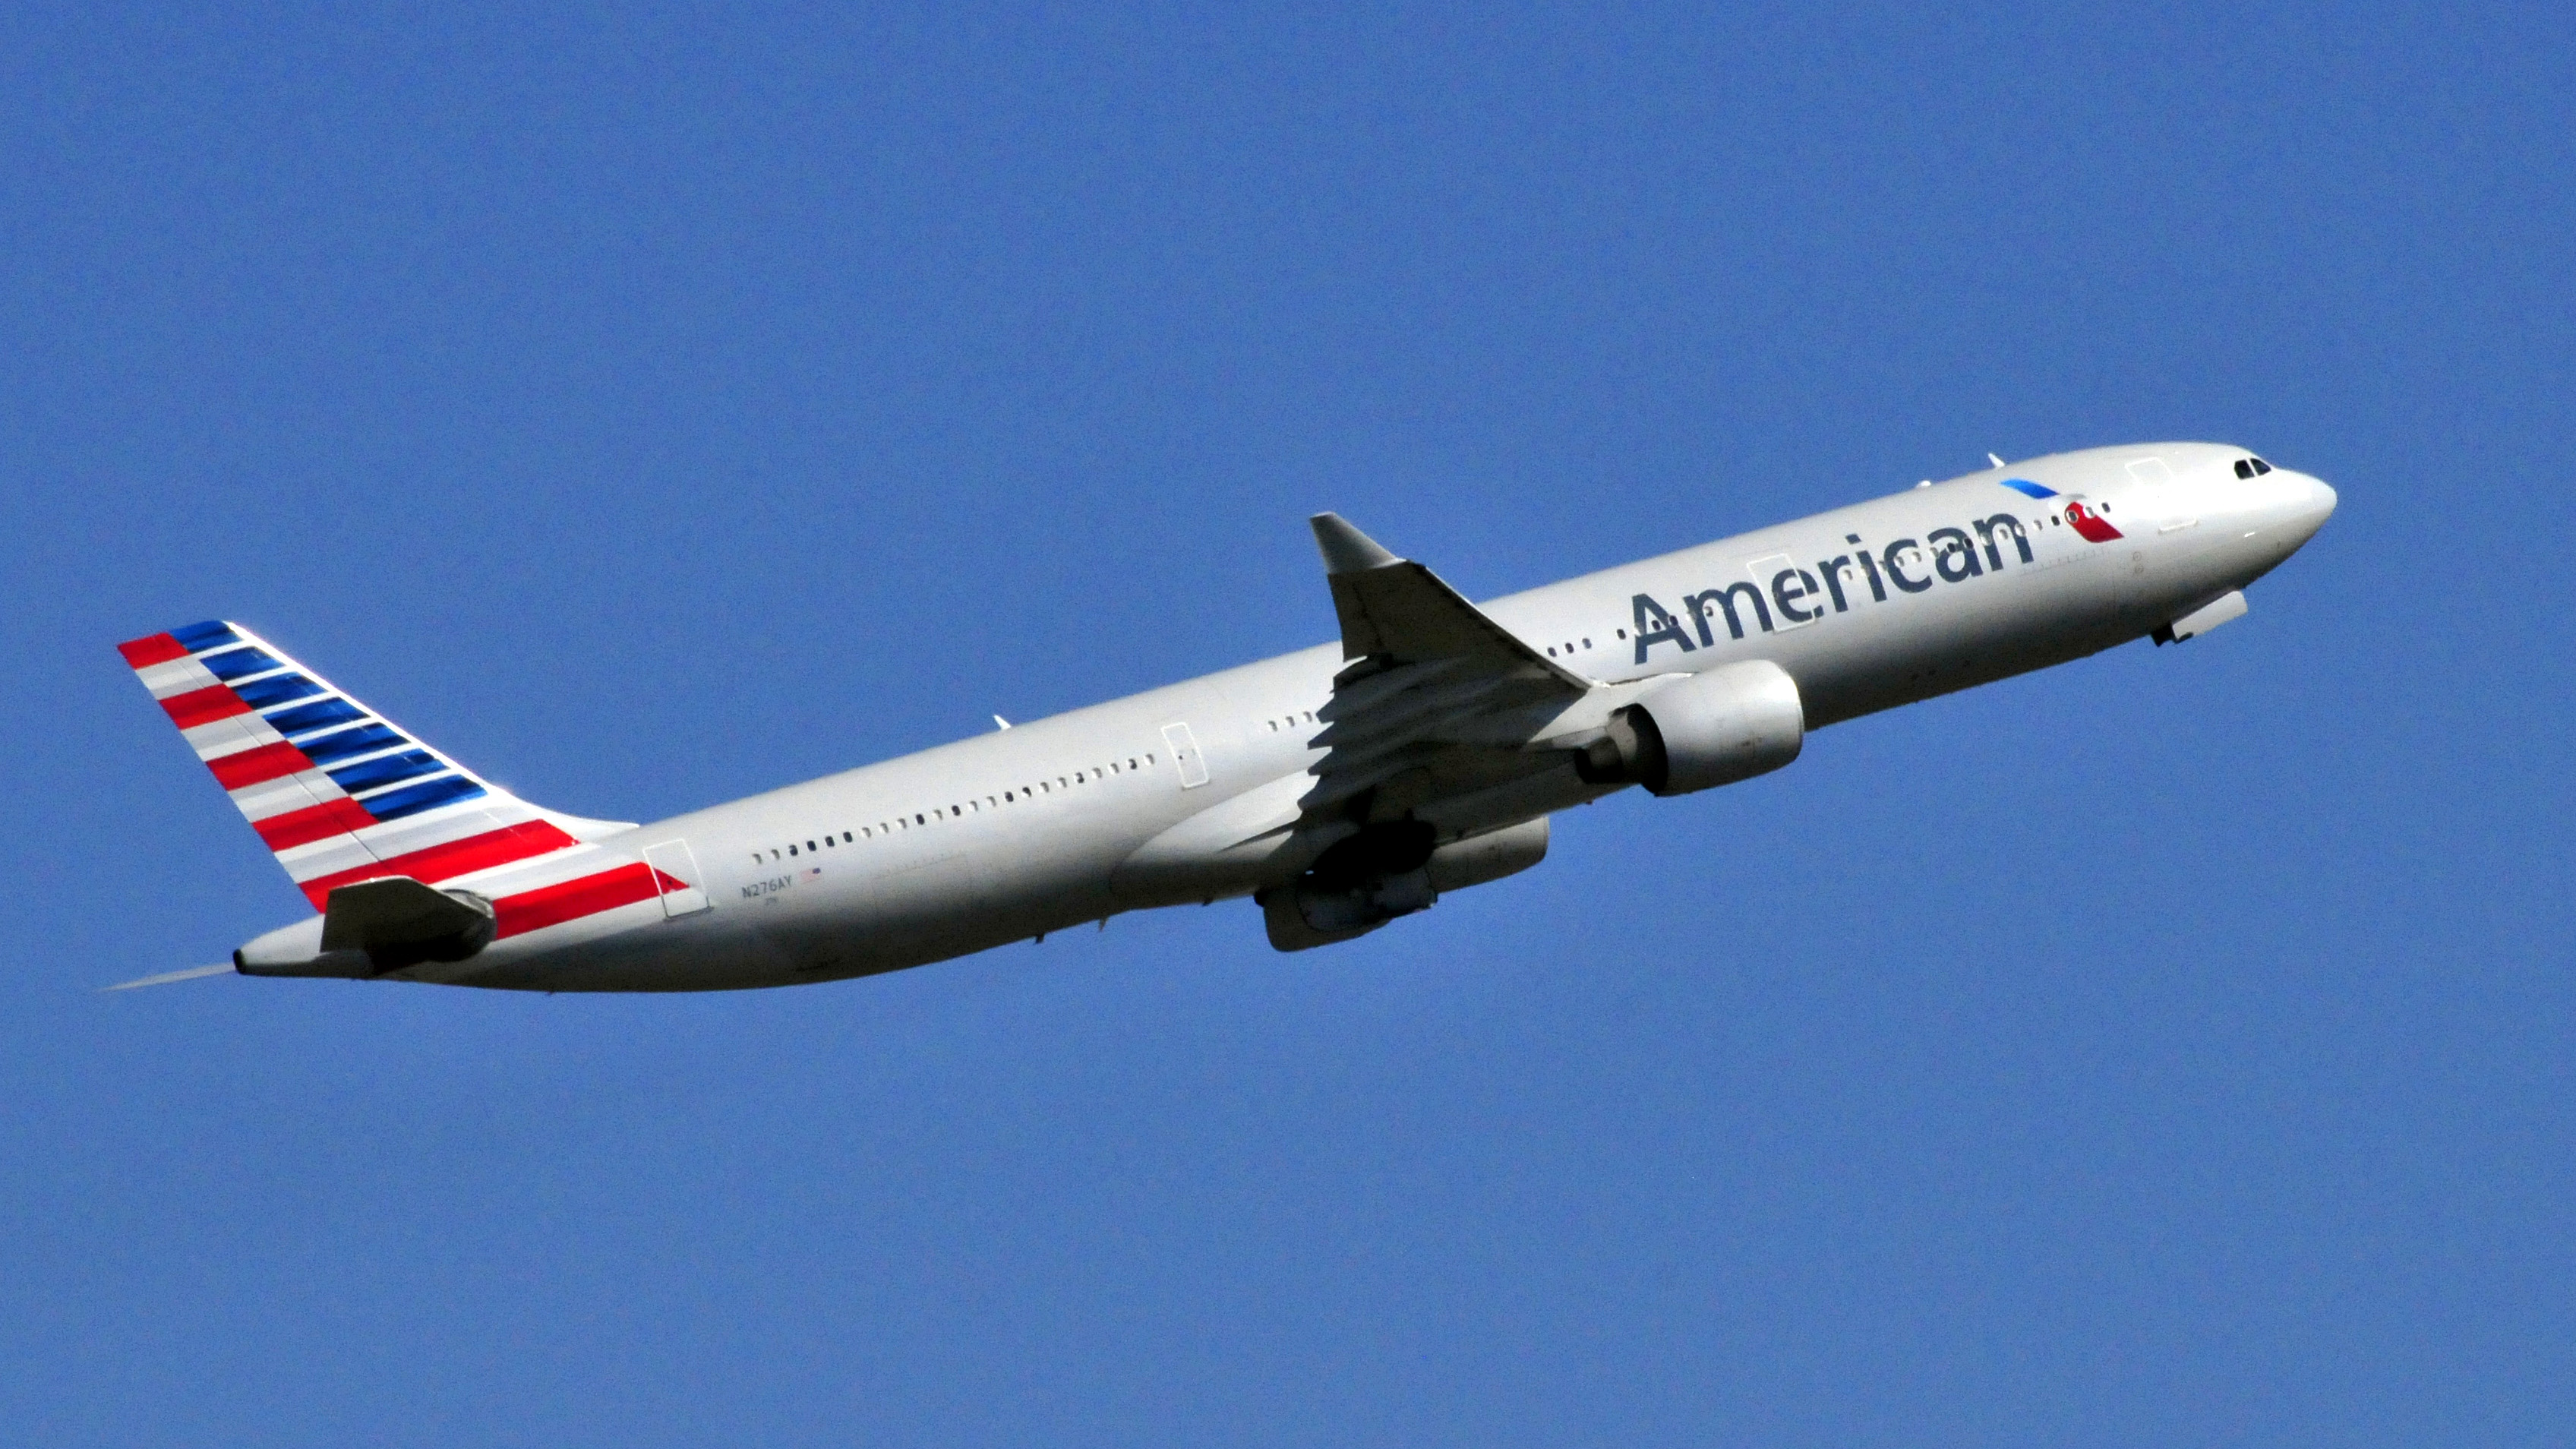

Downloaded and saved: images/satire/image_1689.jpg -> image_1689.jpg


Downloaded and saved: images/satire/image_1023.jpg -> image_1023.jpg


Downloaded and saved: images/satire/image_1338.jpg -> image_1338.jpg


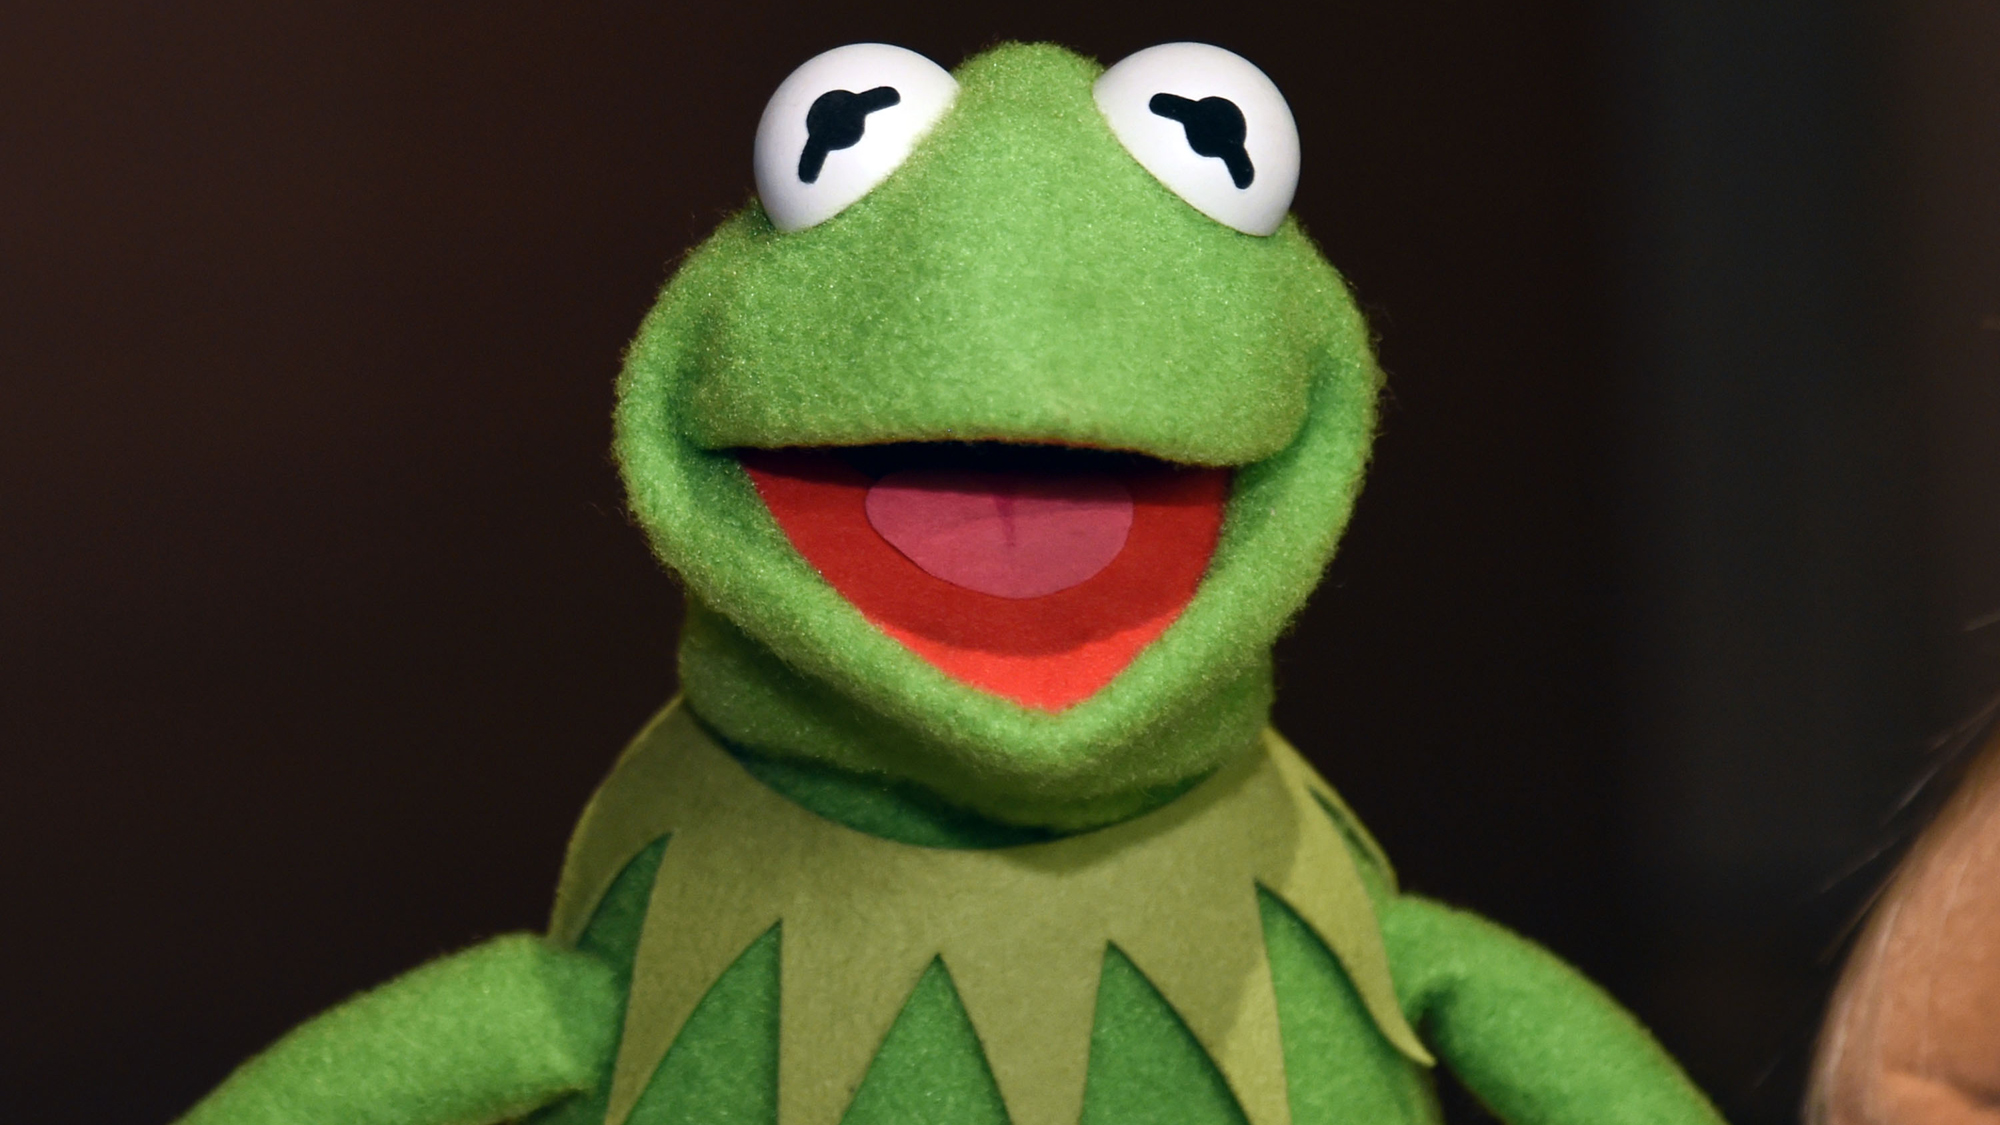

Downloaded and saved: images/satire/image_1219.jpg -> image_1219.jpg
Sample True Images:


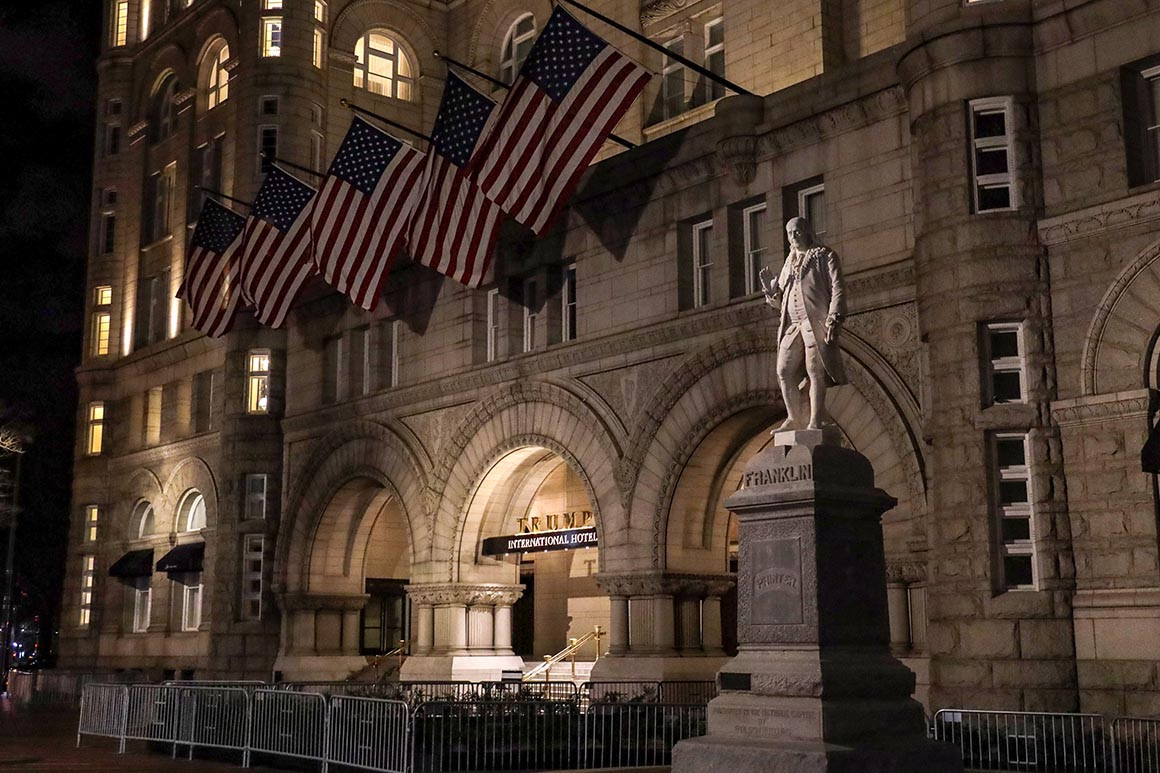

Downloaded and saved: images/true/image_5219.jpg -> image_5219.jpg


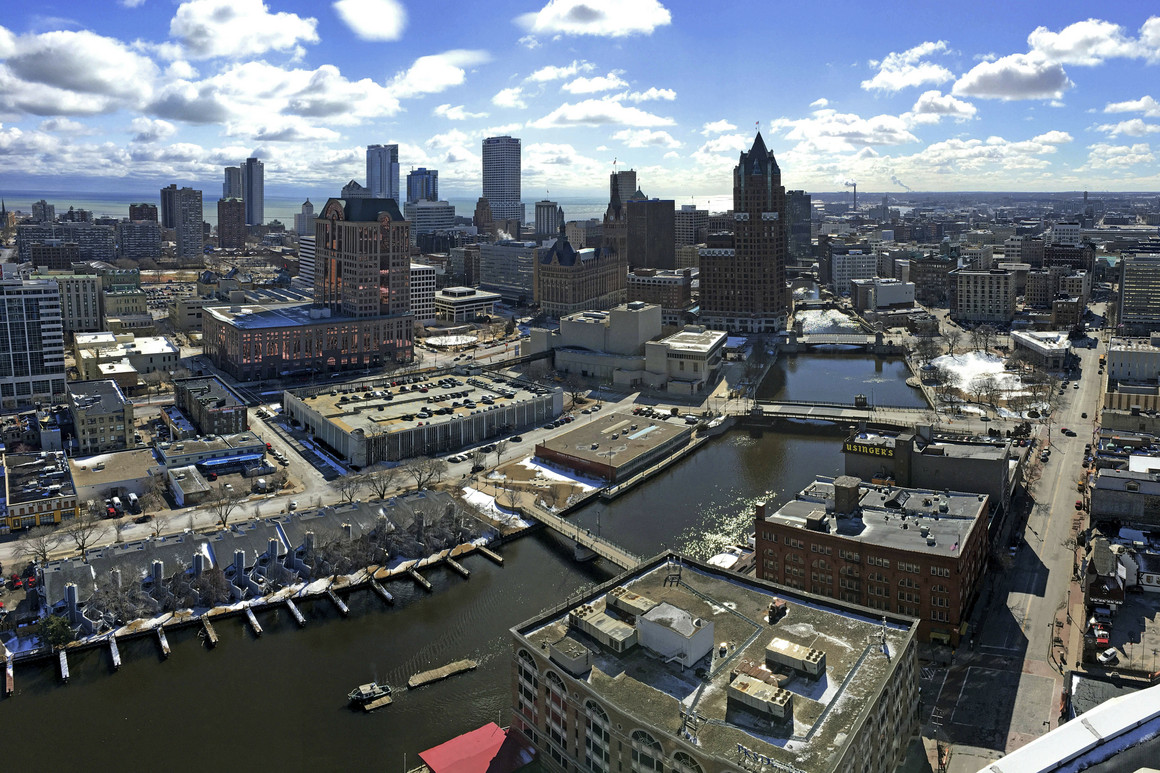

Downloaded and saved: images/true/image_5705.jpg -> image_5705.jpg


Downloaded and saved: images/true/image_5474.jpg -> image_5474.jpg


Downloaded and saved: images/true/image_5357.jpg -> image_5357.jpg


Downloaded and saved: images/true/image_5366.jpg -> image_5366.jpg


In [2]:
import boto3
from PIL import Image
import io
import random
import requests
from IPython.display import display, Image as IPImage


# Function to download and optionally display sample images
def download_and_display_sample_images(s3_bucket, s3_folder, num_samples=5, display_inline=False):
    # List objects in the specified S3 folder
    s3_objects = s3.list_objects_v2(Bucket=s3_bucket, Prefix=s3_folder)

    # Get a random sample of objects
    sample_objects = random.sample(s3_objects.get('Contents', []), num_samples)

    # Iterate through the sample objects, download, and optionally display the images
    for obj in sample_objects:
        s3_object_key = obj['Key']

        try:
            # Download the image from S3
            image_data = s3.get_object(Bucket=s3_bucket, Key=s3_object_key)['Body'].read()

            # Display the image inline if specified
            if display_inline:
                img = IPImage(data=image_data, format='png')
                display(img)

            # Save the image to a local file
            local_file_name = s3_object_key.split('/')[-1]
            with open('images/'+local_file_name, 'wb') as local_file:
                local_file.write(image_data)

            print(f"Downloaded and saved: {s3_object_key} -> {local_file_name}")
        except Exception as e:
            print(f"Error downloading image from S3: {str(e)}")

# Download and optionally display sample satire images inline
print("Sample Satire Images:")
download_and_display_sample_images(s3_bucket, s3_satire_folder, display_inline=True)

# Download and optionally display sample true images inline
print("Sample True Images:")
download_and_display_sample_images(s3_bucket, s3_true_folder, display_inline=True)

In [3]:
import boto3
import random
import requests
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt

# Initialize S3 client
s3 = boto3.client('s3')

# Function to load a subset of images from S3
def load_images_from_s3(s3_bucket, s3_folder, max_images=1400):
    # List objects in the specified S3 folder
    s3_objects = s3.list_objects_v2(Bucket=s3_bucket, Prefix=s3_folder)

    # Initialize a list to store images
    images = []

    # Randomly select a subset of objects
    all_objects = s3_objects.get('Contents', [])
    selected_objects = random.sample(all_objects, min(max_images, len(all_objects)))

    # Iterate through the selected objects and load images
    for obj in selected_objects:
        s3_object_key = obj['Key']

        try:
            # Generate a pre-signed URL for the S3 object
            image_url = s3.generate_presigned_url('get_object', Params={'Bucket': s3_bucket, 'Key': s3_object_key})

            # Send an HTTP GET request to the image URL
            response = requests.get(image_url)

            # Check if the request was successful (status code 200)
            if response.status_code == 200:
                # Open the image using Pillow and convert it to a NumPy array
                img = Image.open(io.BytesIO(response.content))
                img = np.array(img)
                images.append(img)
            else:
                print(f"Failed to download: {image_url} (Status Code: {response.status_code})")
        except Exception as e:
            print(f"Error processing image {s3_object_key}: {str(e)}")

    return images

# Load a subset of satire and true images from S3
satire_images = load_images_from_s3(s3_bucket, s3_satire_folder, max_images=700)
true_images = load_images_from_s3(s3_bucket, s3_true_folder, max_images=700)
print(len(satire_images))
print(len(true_images))

Error processing image images/satire/image_1494.jpg: cannot identify image file <_io.BytesIO object at 0x7f7efd90a220>
Error processing image images/satire/image_1029.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed51a60e0>
Error processing image images/satire/image_1052.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed5378630>
Error processing image images/satire/image_1660.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed51a6220>
Error processing image images/true/image_5571.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed51416d0>
Error processing image images/true/image_5573.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed5141bd0>
Error processing image images/true/image_5512.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed5141450>
Error processing image images/true/image_5820.jpg: cannot identify image file <_io.BytesIO object at 0x7f7ed5141450>
Error processing image images/true/image_5566.jpg: canno

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming satire_images and true_images are loaded as per your existing code

def preprocess_images(images, target_size=(128, 128)):
    """
    Resize, ensure RGB format, and normalize a list of images.
    """
    preprocessed = []
    for idx, img in enumerate(images):
        try:
            img_rgb = Image.fromarray(img).convert('RGB')
            resized = np.array(img_rgb.resize(target_size))
            normalized = resized / 255.0
            preprocessed.append(normalized)
        except Exception as e:
            print(f"Error processing image {idx}: {str(e)}")
            continue
    return np.array(preprocessed)

satire_images_processed = preprocess_images(satire_images)
true_images_processed = preprocess_images(true_images)

# Create labels for the images
satire_labels = [1] * len(satire_images_processed)
true_labels = [0] * len(true_images_processed)

# Concatenate images and labels
X = np.concatenate((satire_images_processed, true_images_processed), axis=0)
y = np.concatenate((satire_labels, true_labels), axis=0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base_model
base_model.trainable = False

# Create a new input layer (optional, depends on your data)
input_layer = Input(shape=(128, 128, 3))

# Add custom layers on top of the base model
x = base_model(input_layer)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Add dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=input_layer, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

2023-11-15 07:06:52.681459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-15 07:06:53.256099: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-11-15 07:06:53.259970: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:105] SageMaker Profiler is not enabled. The timeline writer thread will not be started, future recorded events will be dropped.
2023-11-15 07:06:53.512128: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-11-15 07:06:57.832405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following

In [7]:
# Set the number of epochs for training
number_of_epochs = 10  # can adjust

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=number_of_epochs,
    batch_size=32  #adjust the batch size based on computational resources
)


Epoch 1/10
35/35 [==============================] - 7s 128ms/step - loss: 0.7475 - accuracy: 0.7013 - val_loss: 0.3820 - val_accuracy: 0.8109
Epoch 2/10
35/35 [==============================] - 4s 101ms/step - loss: 0.3620 - accuracy: 0.8443 - val_loss: 0.4128 - val_accuracy: 0.8182
Epoch 3/10
35/35 [==============================] - 3s 98ms/step - loss: 0.2815 - accuracy: 0.8898 - val_loss: 0.4052 - val_accuracy: 0.8073
Epoch 4/10
35/35 [==============================] - 3s 92ms/step - loss: 0.2119 - accuracy: 0.9071 - val_loss: 0.3869 - val_accuracy: 0.8291
Epoch 5/10
35/35 [==============================] - 3s 87ms/step - loss: 0.1441 - accuracy: 0.9517 - val_loss: 0.4161 - val_accuracy: 0.8364
Epoch 6/10
35/35 [==============================] - 3s 86ms/step - loss: 0.1035 - accuracy: 0.9699 - val_loss: 0.4034 - val_accuracy: 0.8436
Epoch 7/10
35/35 [==============================] - 3s 87ms/step - loss: 0.0671 - accuracy: 0.9882 - val_loss: 0.4165 - val_accuracy: 0.8436
Epoch 8/10


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Make predictions on test set 
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary predictions

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))


9/9 [==============================] - 1s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       134
           1       0.89      0.84      0.86       141

    accuracy                           0.86       275
   macro avg       0.86      0.86      0.86       275
weighted avg       0.86      0.86      0.86       275

Confusion Matrix:
[[119  15]
 [ 23 118]]


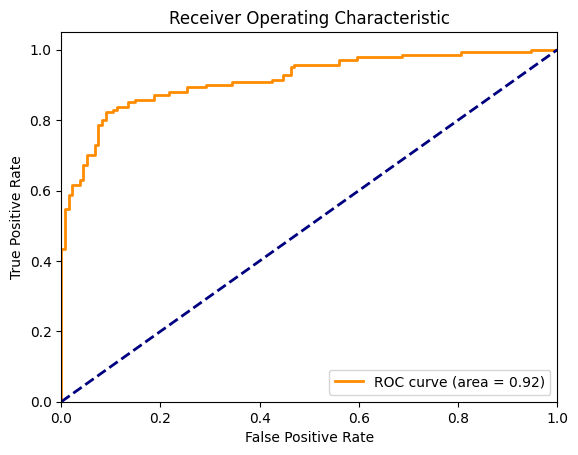

In [10]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


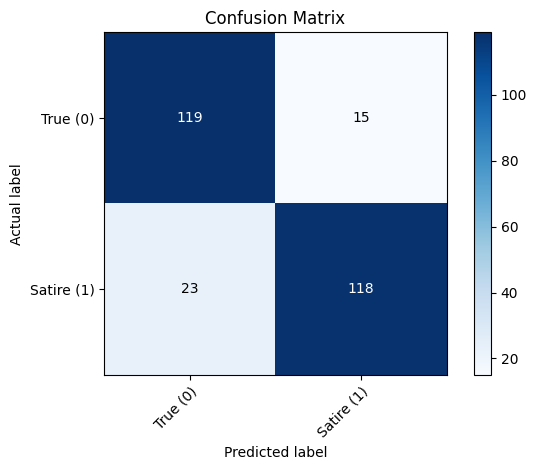

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion Matrix Data
cm = np.array([[119, 15],
               [23, 118]])

# Labels for axes
classes = ['True (0)', 'Satire (1)']

fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Show all ticks and label them
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion Matrix',
       ylabel='Actual label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout()
plt.show()


